In [ ]:
!pip install pyldavis

In [ ]:
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from collections import Counter
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import seaborn as sns

In [ ]:
kagTweets = pd.read_csv('dataForSolr_v2.csv') #Change this with the name of your downloaded file
kagTweets.head()

username  ... weightedSentimentNorm
0         cian2me  ...              0.003204
1  cheekymiller89  ...              0.004231
2       himabista  ...              0.000964
3         abmowat  ...              0.000000
4  trevahhhNstuff  ...              0.000000

[5 rows x 11 columns]

In [ ]:
airCounts = dict(Counter(kagTweets['sentiment']))

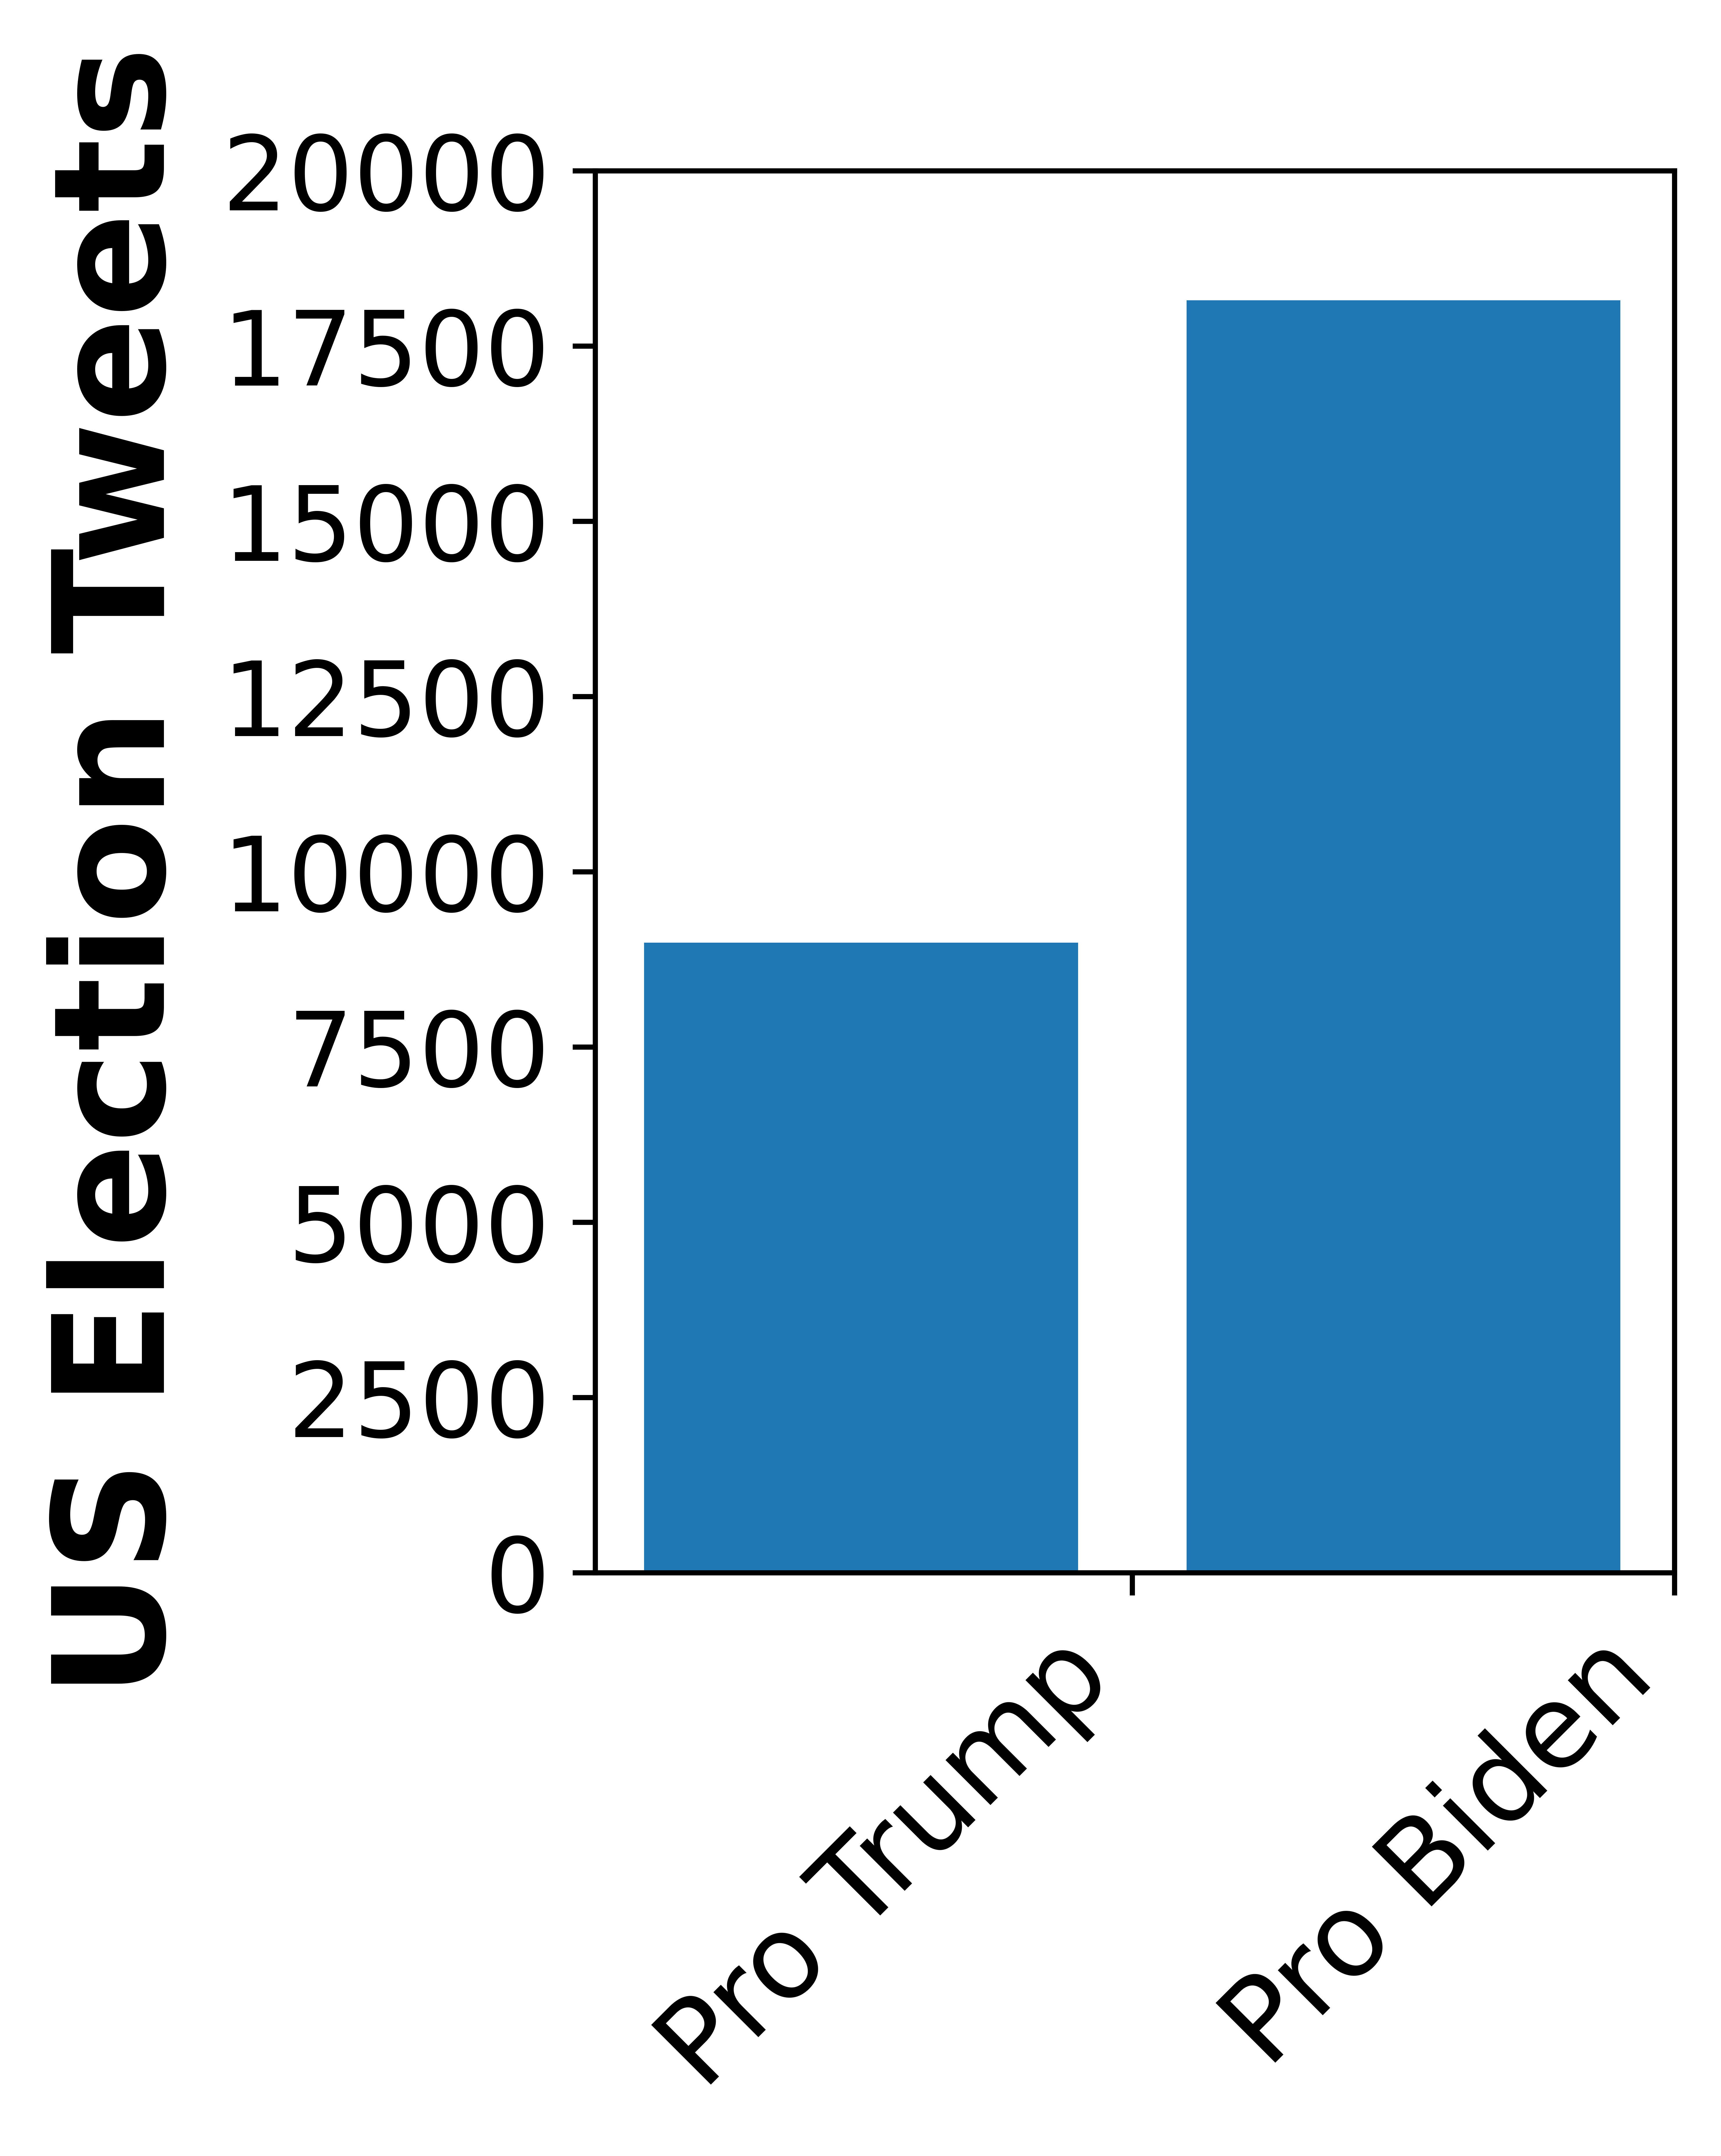

In [ ]:
fig = plt.figure(figsize=(3,4), dpi=1600)
ax = plt.subplot(111)

barPlot = plt.bar(range(len(airCounts)),airCounts.values())#,color=[c[4],c[4],c[3],c[3]])
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in barPlot]
plt.xticks([i+0.5 for i in range(len(airCounts.keys()))],airCounts.keys(),rotation=45,ha='right',fontsize=18)
ax.set_ylabel('US Election Tweets',fontsize=24,fontweight='bold')

yTix = plt.yticks()[0]
plt.yticks(yTix,fontsize=16)

plt.show()

In [ ]:
kagTweets['content'][136]

'@Schwarzenegger @JoeBiden @KamalaHarris Congrats from Graz/Austria. Now it seams, that everything is getting better. Please protect this wonderful president!🇦🇹🇺🇸👍'

In [ ]:
from gensim import corpora, models
from gensim.similarities import MatrixSimilarity
from gensim.utils import SaveLoad
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from re import sub
import pyLDAvis.gensim_models
from collections import Counter
from gensim.matutils import corpus2csc, sparse2full, corpus2dense
from wordcloud import WordCloud
from sklearn.utils import resample

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [ ]:
#Functions for data cleaning
wnl = WordNetLemmatizer()

def removePunc(myWord):
    """Function to remove punctuation from string inputs"""
    if myWord is None:
        return myWord
    else:
        return sub(r'[.:;()/!&-*@$,?^\d+]','',myWord)
        
def removeAscii(myWord):
    """Function to remove ascii from string input"""
    if myWord is None:
        return myWord
    else:
        return str(sub(r'[^\x00-\x7F]+','', myWord))

def lemmatize(myWord):
    """Function to lemmatize words"""
    if myWord is None:
        return myWord
    else:
        return str(wnl.lemmatize(myWord))

def removeStopWords(myWord):
    """Function to remove stop words"""
    if myWord is None:
        return myWord
    if myWord not in str(stopwords.words('english')):
        return myWord

def removeLinkUser(myWord):
    """Function to remove web addresses and twitter handles"""
    if not myWord.startswith('http'):
        return myWord

def prepText(myWord):
    """Final text pre-processing function"""
    return removeStopWords(
        lemmatize(
            removeAscii(
                removePunc(
                    removeLinkUser(
                        myWord.lower()
                    )
                )
            )
        )
    )

In [ ]:
def filterTweetList(tweetList):
    """Remove stop words, lemmatize, and clean all tweets"""
    return [[prepText(word) for word
                in tweet.split()
                    if prepText(word) is not None]
                for tweet in tweetList]

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
kagTweets['content'][136]

'@Schwarzenegger @JoeBiden @KamalaHarris Congrats from Graz/Austria. Now it seams, that everything is getting better. Please protect this wonderful president!🇦🇹🇺🇸👍'

In [ ]:
cleanKagTweetList = filterTweetList(kagTweets['content'])

In [ ]:
cleanKagTweetList[136]

['schwarzenegger',
 'joebiden',
 'kamalaharris',
 'congrats',
 'grazaustria',
 'seam',
 'everything',
 'getting',
 'better',
 'please',
 'protect',
 'wonderful',
 'president']

In [ ]:
def makeDict(myTweetList):
    """Create dictionary from list of tokenized documents"""
    return corpora.Dictionary(myTweetList)

def makeCorpus(myTweetList,myDict):
    """Create corpus from list of tokenized documents"""
    return [myDict.doc2bow(tweet) for tweet in myTweetList]

def createLDA(myCorpus, myDictionary,myTopics=10,myPasses=10,myIterations=50,myAlpha=0.001):
    """LDA model call function"""
    return models.LdaMulticore(myCorpus, id2word=myDictionary, num_topics=myTopics, passes=myPasses,
    iterations=myIterations,alpha=myAlpha)

In [ ]:
"""Create model objects"""
kagDict   = makeDict(cleanKagTweetList)
kagCorpus = makeCorpus(cleanKagTweetList, kagDict)
kagLda = createLDA(kagCorpus, kagDict)

"""Save model objects"""
SaveLoad.save(kagLda,'kaggleLDAmodel')
corpora.MmCorpus.serialize('kaggleCorpus.mm', kagCorpus)
kagDict.save('kaggleDictionary.dict')

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [ ]:
pyLDAvis.enable_notebook()
ldaViz = pyLDAvis.gensim_models.prepare(kagLda, kagCorpus, kagDict)

In [ ]:
ldaViz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.254723 -0.069953       1        1  16.495046
4     -0.071014 -0.138522       2        1  14.993954
1     -0.135102 -0.102469       3        1  14.403097
7     -0.030348 -0.085247       4        1  10.333135
5      0.250603 -0.059306       5        1   9.783095
8     -0.101746 -0.098043       6        1   8.838560
9      0.011571  0.226908       7        1   7.841143
3     -0.129498  0.027517       8        1   7.584041
6     -0.107747  0.121104       9        1   6.335805
0      0.058557  0.178012      10        1   3.392124, topic_info=                Term         Freq        Total Category  logprob  loglift
20          joebiden  7363.000000  7363.000000  Default  30.0000  30.0000
64               joe  3159.000000  3159.000000  Default  29.0000  29.0000
44             trump  7219.000000  7219.000000  Default  28.0000  28.0000
0              biden  6711.000000  6711.000000  Default  27.0000  27.0000
190           donald  3067.000000  3067.000000  Default  26.0000  26.0000
..               ...          ...          ...      ...      ...      ...
271          youtube    21.203569   133.627223  Topic10  -6.1658   1.5428
64               joe    28.349081  3159.476267  Topic10  -5.8754  -1.3299
50            bidens    22.940197   391.445913  Topic10  -6.0871   0.5468
615           change    22.050926   263.449594  Topic10  -6.1266   0.9032
77   president-elect    22.532824   465.878134  Topic10  -6.1050   0.3548

[722 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
1546      5  0.992335             "joe
5842      9  0.955621          "sleepy
70        1  0.386606  #americadecides
70        5  0.090375  #americadecides
70        7  0.517149  #americadecides
...     ...       ...              ...
271      10  0.157154          youtube
6794      3  0.992024             zero
939       1  0.065849                |
939       2  0.895550                |
939      10  0.026340                |

[1525 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 8, 6, 9, 10, 4, 7, 1])

In [ ]:
wc = WordCloud()

In [ ]:
temp = ''
for i in cleanKagTweetList:
  temp += ' '.join(i)
  temp = temp + ' '


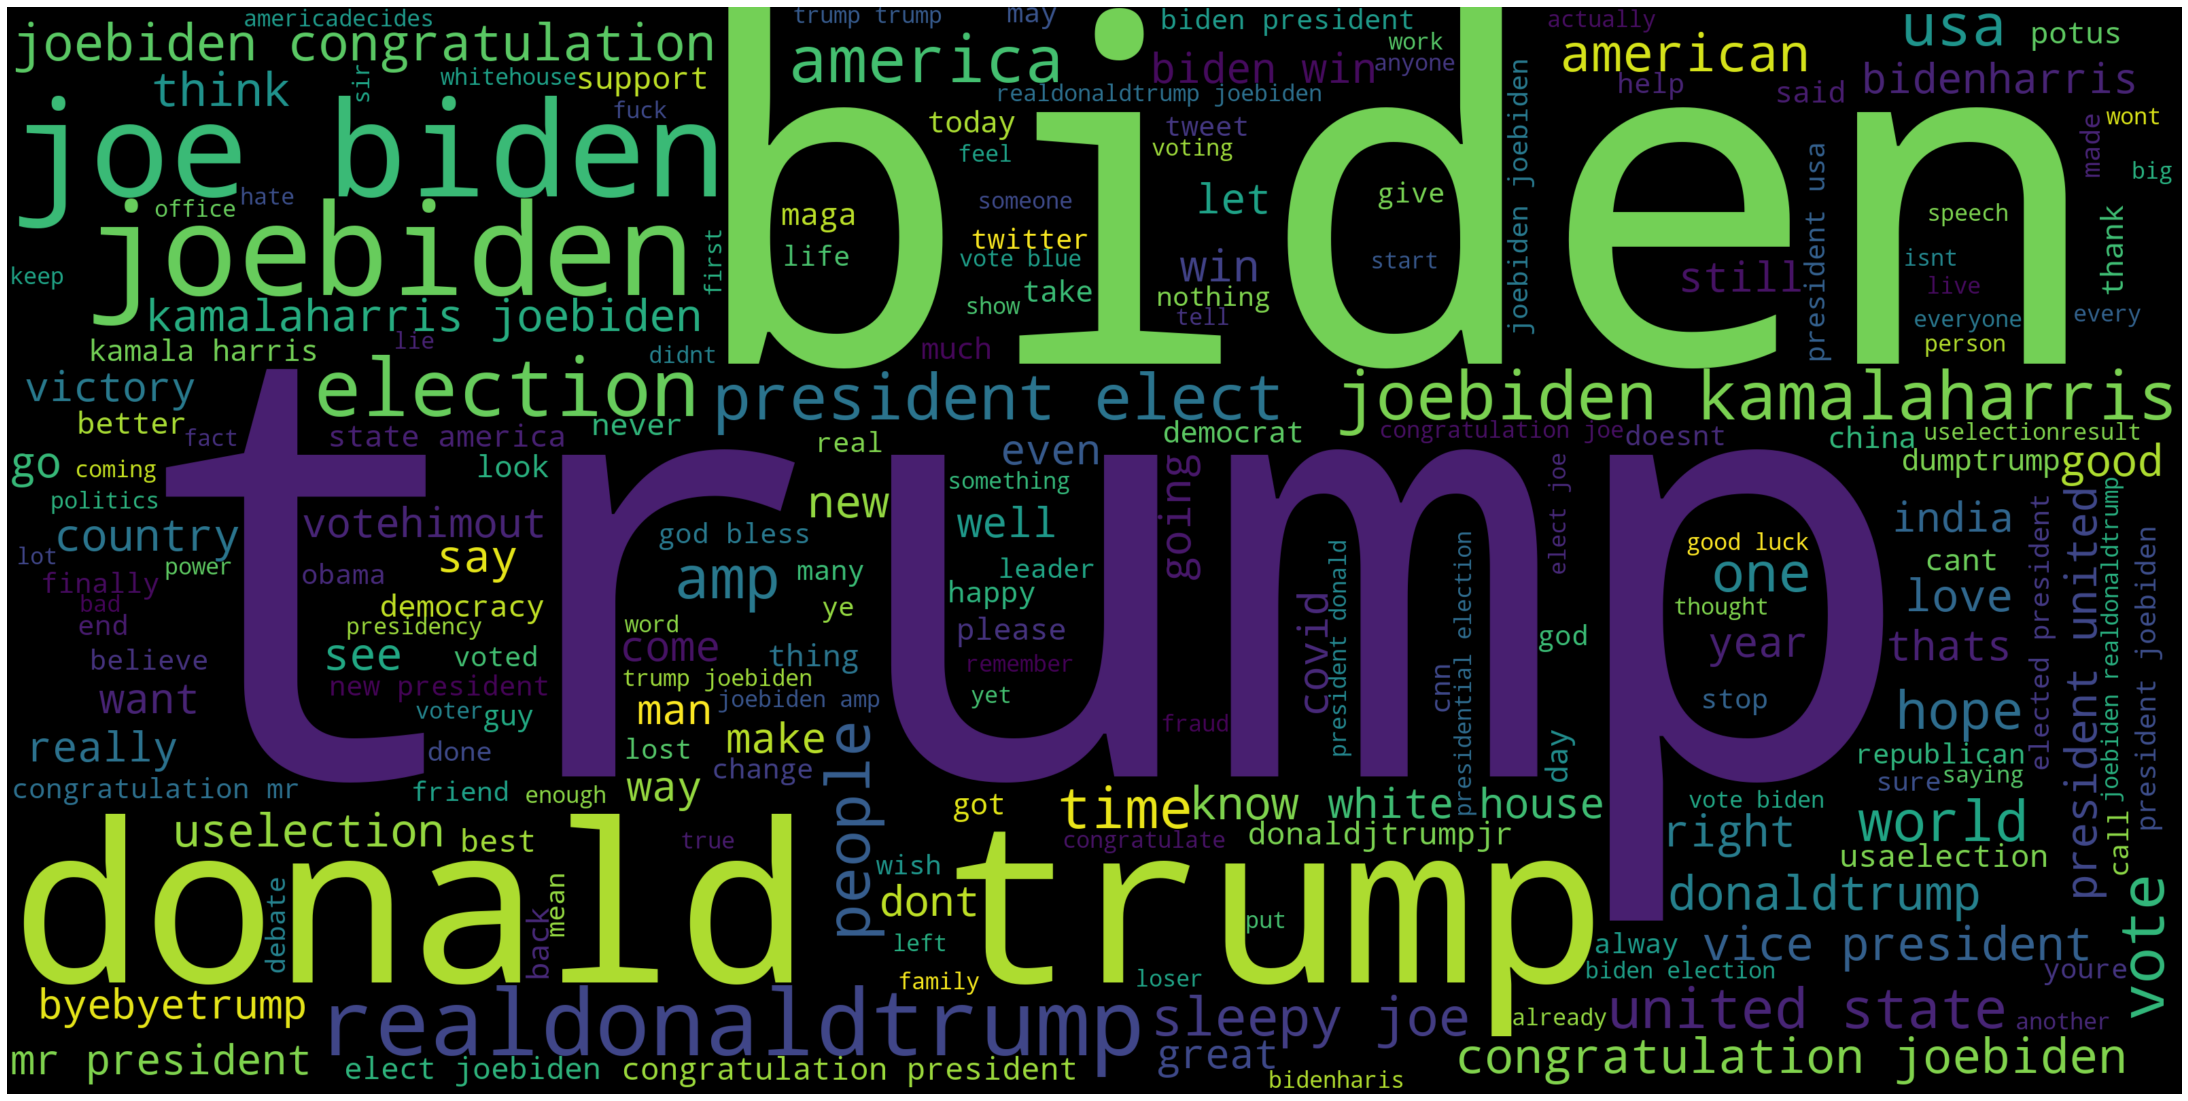

In [ ]:
# import matplotlib.pyplot as plt
# plt.imshow(img, interpolation='bilinear')
# plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(width=3200, height=1600).generate(temp)
plt.figure( figsize=(40,20) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
trumpTweets = kagTweets[kagTweets['sentiment'] == 'Pro Trump']
bidenTweets = kagTweets[kagTweets['sentiment'] == 'Pro Biden']

In [ ]:
print(trumpTweets['sentiment'].count(), bidenTweets['sentiment'].count())

8992 18154


In [ ]:
cleanTrumpKagTweetList = filterTweetList(trumpTweets['content'])
cleanBidenKagTweetList = filterTweetList(bidenTweets['content'])

In [ ]:
tempTrump = ''
for i in cleanTrumpKagTweetList:
  tempTrump += ' '.join(i)
  tempTrump = tempTrump + ' '

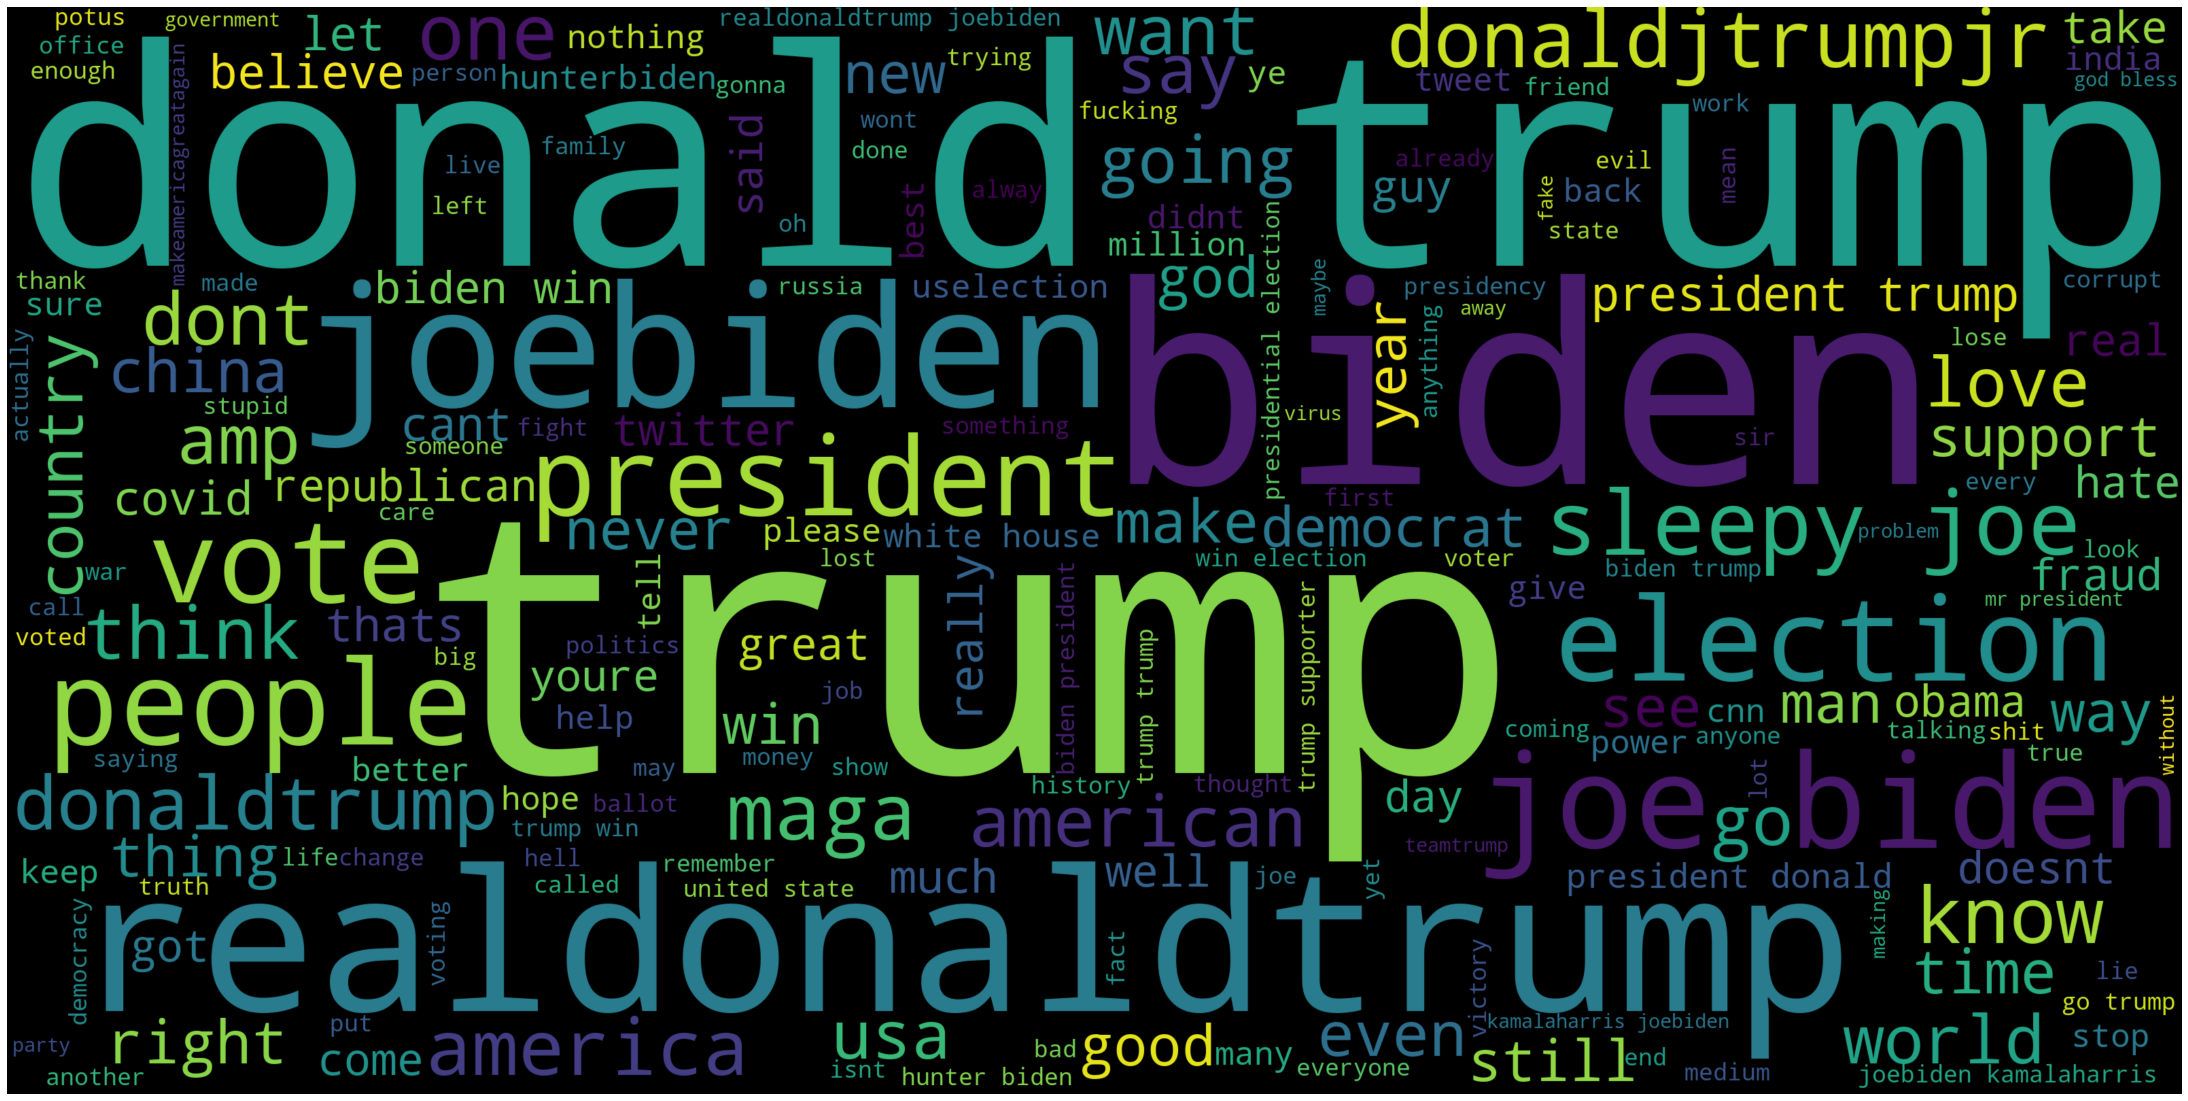

In [ ]:
wordcloud = WordCloud(width=3200, height=1600).generate(tempTrump)
plt.figure( figsize=(40,20) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
tempBiden = ''
for i in cleanBidenKagTweetList:
  tempBiden += ' '.join(i)
  tempBiden = tempBiden + ' '

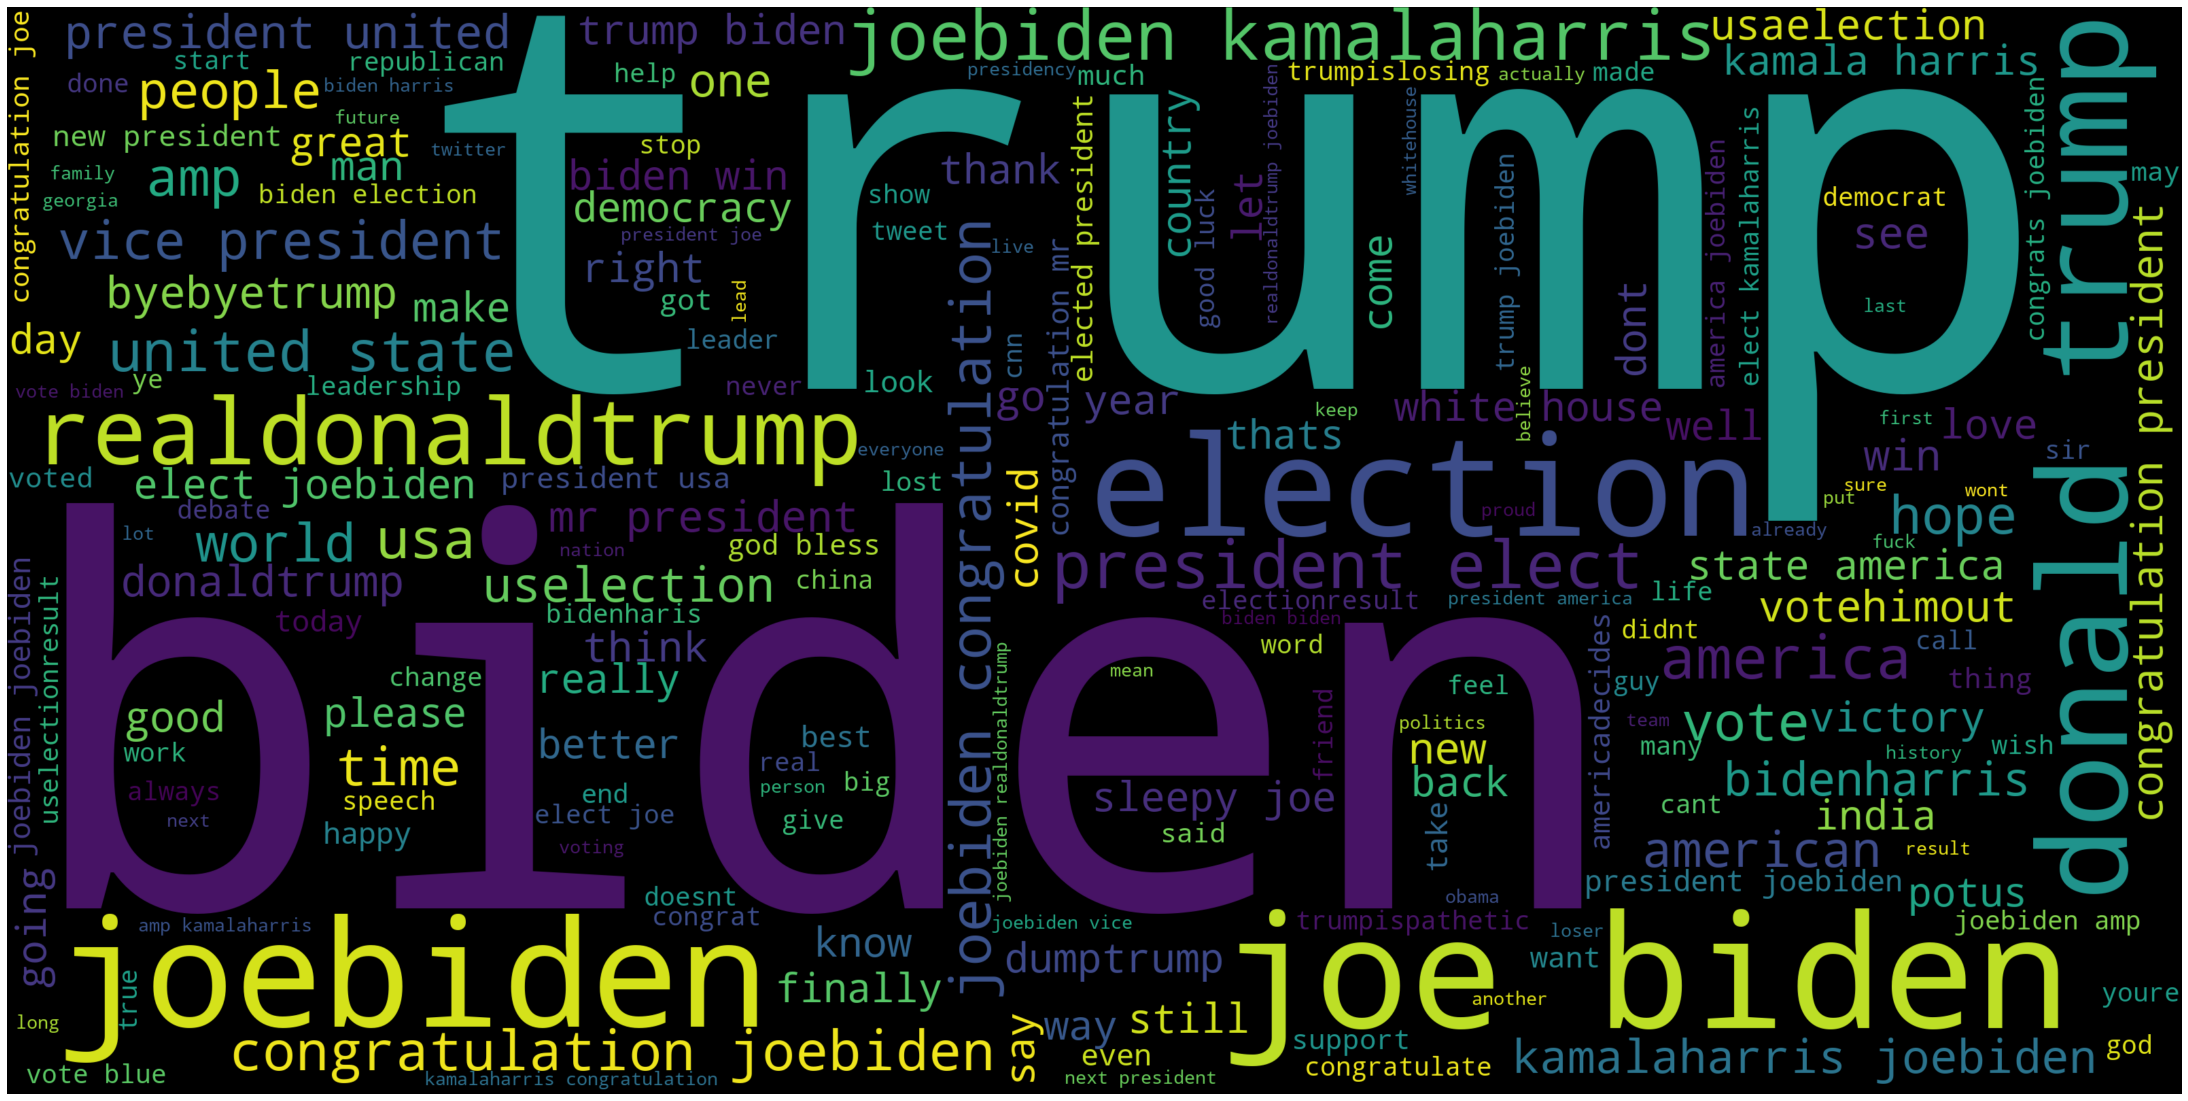

In [ ]:
wordcloud = WordCloud(width=3200, height=1600).generate(tempBiden)
plt.figure( figsize=(40,20) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
"""Create model objects"""
kagDict   = makeDict(cleanTrumpKagTweetList)
kagCorpus = makeCorpus(cleanTrumpKagTweetList, kagDict)
kagLda = createLDA(kagCorpus, kagDict)

"""Save model objects"""
SaveLoad.save(kagLda,'kaggleLDAmodel')
corpora.MmCorpus.serialize('kaggleCorpus.mm', kagCorpus)
kagDict.save('kaggleDictionary.dict')

In [ ]:
pyLDAvis.enable_notebook()
ldaViz = pyLDAvis.gensim_models.prepare(kagLda, kagCorpus, kagDict)

In [ ]:
ldaViz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.064979  0.014013       1        1  15.690188
1      0.080209 -0.032343       2        1  13.978632
7      0.089140 -0.032116       3        1  13.508596
2      0.006272 -0.002552       4        1  11.181736
5     -0.012051 -0.072737       5        1  11.139178
0      0.039085  0.046386       6        1   8.772535
4      0.104090  0.067859       7        1   8.227985
6     -0.067054 -0.040285       8        1   6.536755
8     -0.152352  0.166707       9        1   5.606099
9     -0.152318 -0.114933      10        1   5.358296, topic_info=            Term         Freq        Total Category  logprob  loglift
64        donald  1804.000000  1804.000000  Default  30.0000  30.0000
133          joe   988.000000   988.000000  Default  29.0000  29.0000
380       sleepy   374.000000   374.000000  Default  28.0000  28.0000
15         trump  3702.000000  3702.000000  Default  27.0000  27.0000
26          vote   586.000000   586.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
0          biden    23.253377  2263.219396  Topic10  -5.4724  -1.6516
136  #uselection    11.497388    62.238105  Topic10  -6.1768   1.2377
320        think    12.793083   346.740439  Topic10  -6.0700  -0.3731
164         dont    12.897264   465.886047  Topic10  -6.0619  -0.6604
132        great    11.761230   158.675922  Topic10  -6.1541   0.3245

[788 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4264     10  0.921177   "biden
4967      1  0.914674  "donald
4967      6  0.076223  "donald
664       1  0.332349     "joe
664       9  0.664698     "joe
...     ...       ...      ...
1117      2  0.857938    youve
1117      4  0.063551    youve
1117     10  0.063551    youve
3305      5  0.246317     zero
3305     10  0.738951     zero

[1795 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 8, 3, 6, 1, 5, 7, 9, 10])

In [ ]:
"""Create model objects"""
kagDict   = makeDict(cleanBidenKagTweetList)
kagCorpus = makeCorpus(cleanBidenKagTweetList, kagDict)
kagLda = createLDA(kagCorpus, kagDict)

"""Save model objects"""
SaveLoad.save(kagLda,'kaggleLDAmodel')
corpora.MmCorpus.serialize('kaggleCorpus.mm', kagCorpus)
kagDict.save('kaggleDictionary.dict')

In [ ]:
pyLDAvis.enable_notebook()
ldaViz = pyLDAvis.gensim_models.prepare(kagLda, kagCorpus, kagDict)

In [ ]:
ldaViz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.265084  0.121224       1        1  27.376946
0     -0.041315 -0.175153       2        1  16.201518
7      0.016688 -0.150445       3        1  10.517031
4     -0.083923 -0.020095       4        1  10.187854
2     -0.074030 -0.032904       5        1   9.682737
9      0.023522 -0.056603       6        1   7.089333
1     -0.006480  0.004759       7        1   6.798723
8      0.226894 -0.060427       8        1   4.710400
5      0.060115  0.176370       9        1   4.347575
6      0.143613  0.193274      10        1   3.087884, topic_info=               Term         Freq        Total Category  logprob  loglift
29   congratulation  2833.000000  2833.000000  Default  30.0000  30.0000
31        president  3207.000000  3207.000000  Default  29.0000  29.0000
40            trump  3085.000000  3085.000000  Default  28.0000  28.0000
13         joebiden  6458.000000  6458.000000  Default  27.0000  27.0000
52     kamalaharris  1872.000000  1872.000000  Default  26.0000  26.0000
..              ...          ...          ...      ...      ...      ...
35            going    28.408531   303.526468  Topic10  -5.3530   1.1089
92             well    28.230417   367.723958  Topic10  -5.3593   0.9108
20           #biden    32.323127  1709.119631  Topic10  -5.2239  -0.4903
21     #bidenharris    25.226877   932.075311  Topic10  -5.4718  -0.1318
620            look    23.173689   291.126024  Topic10  -5.5567   0.9469

[658 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
16694      8  0.983260     "most
26087     10  0.980722  "totally
9695       8  0.976082    "youre
542        1  0.132699         #
542        4  0.122491         #
...      ...       ...       ...
2827       6  0.246542     youve
2827       9  0.739626     youve
179        3  0.916719        yr
179        6  0.058514        yr
13981      4  0.987817      zero

[1229 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 8, 5, 3, 10, 2, 9, 6, 7])